The objective of this preprocessing phase is therefore to transform raw French citizen proposals into **lemmatized and semantically meaningful token sequences**, minimizing noise and redundancy while maintaining the linguistic richness necessary for later analysis.

In this study, we employ **spaCy**, an advanced Natural Language Processing (NLP) library, to perform linguistic preprocessing. 
spaCy is chosen because it provides a **robust, linguistically informed pipeline** that integrates tokenization, part-of-speech tagging, lemmatization, and stopword detection in a computationally efficient framework.  

Unlike simple text cleaning libraries, spaCy relies on **statistical language models** trained on large corpora.  
This allows it to handle **morphological variation** (e.g., verb conjugations, plural forms) and **syntactic segmentation** (e.g., multi-word expressions, punctuation boundaries) in a way that preserves linguistic meaning.

### 1. Configuration and Data Loading

The script begins by defining several configuration parameters:

- **`INPUT`**: path to the source Excel file (`makeorg_biodiversite.xlsx`), which contains the citizen proposals.  
- **`OUTPUT`**: destination file for saving the processed dataset.  
- **`TEXT_COL`**: the column containing the raw textual content (`"Proposition"`).  
- **`NEW_COL`**: the name of the new column where cleaned and lemmatized tokens will be stored (`"Tokens_lemmas"`).  
- **`MODEL`**: the linguistic model loaded from spaCy (`"fr_core_news_sm"`), providing the French tokenizer, lemmatizer, and stopword list.

The dataset is imported using `pandas.read_excel()`.  
An integrity check ensures that the column specified in `TEXT_COL` exists in the dataset; otherwise, an informative error message lists the available columns.  

### 2. Text Normalization

Before tokenization, we remove a recurring and semantically uninformative expression often found in participatory texts:  
phrases that begin with *"Il faut..."*.  
This is accomplished using a **regular expression** (`regex=True`), which identifies and removes this phrase regardless of capitalization.
This normalization step reduces lexical bias and focuses the subsequent analysis on the **substantive content** of each proposal rather than on stylistic or normative formulations.

In [1]:
import pandas as pd
import spacy

# CONFIGURATION

INPUT = "makeorg_biodiversite.xlsx"
OUTPUT = "output.xlsx"
TEXT_COL = "Proposition"
NEW_COL = "Tokens_lemmas"
MODEL = "fr_core_news_sm"

# READ DATA
df = pd.read_excel(INPUT)

if TEXT_COL not in df.columns:
    raise ValueError(f"Column '{TEXT_COL}' not found. Available: {list(df.columns)}")

# remove leading “Il faut …”
df[TEXT_COL] = df[TEXT_COL].str.replace(r'^\s*Il faut\s+', '', case=False, regex=True)



## 3. Cleaning and Lemmatization Function

The function **`doc_to_lemmas(doc)`** constitutes the core of the preprocessing model.  
It converts each spaCy `Doc` object into a list of **cleaned lemmas**, performing a sequence of linguistic filtering operations:

For each token `tok` in the document, the function applies the following exclusion rules:

1. **Punctuation and Spaces** — tokens identified as punctuation marks or whitespace (`tok.is_punct` or `tok.is_space`) are removed.  
2. **Stopwords** — tokens recognized as grammatical or high-frequency words (e.g., *le, de, un, que*) are filtered out using spaCy’s built-in stopword detection (`tok.is_stop`).  
3. **Numerical Tokens** — any token that represents a number or contains digits (`tok.like_num` or any digit in `tok.text`) is discarded.  
   This removes irrelevant numeric data that do not contribute to thematic meaning.

Tokens that pass the filters are then lemmatized:  
their base or dictionary form is extracted (`tok.lemma_`), converted to lowercase, and appended to a list of lemmas.

This procedure ensures that **inflectional variants** (e.g., *plantes*, *plantons*, *planté*) are mapped to a single canonical form (*planter*).  
By reducing morphological variation, the vocabulary becomes more compact and semantically consistent—properties.

In [2]:
# DEFINE CLEANING FUNCTION

def doc_to_lemmas(doc):
    
    lemmas = []
    for tok in doc:
        if tok.is_punct or tok.is_space:
            continue
        if tok.is_stop:  # automatic stopword detection 
            continue
        if tok.like_num or any(ch.isdigit() for ch in tok.text):
            continue
        if tok.is_alpha or any(ch.isdigit() for ch in tok.text):
            lemma = tok.lemma_.lower()
            lemmas.append(lemma)
    return lemmas

Then we convert the textual column of the dataset into a clean list of string objects suitable for NLP processing.
Specifically, it:
1. Extracts the column defined in TEXT_COL from the DataFrame;
2. Replaces missing values (NaN) with empty strings;
3. Converts the resulting Series into a Python list.

This line applies the **spaCy language model** to the entire list of texts using *streamed batch processing*.  
The method `nlp.pipe()` yields one processed **`Doc` object** per text, each containing **tokens**, **lemmas**, and **part-of-speech annotations**.

The parameters `disable=["parser", "ner"]` deactivate two spaCy components:
- the **syntactic parser**, which analyzes grammatical structure, and  
- the **Named Entity Recognizer (NER)**, which identifies named entities (e.g., persons, organizations, locations).  

In [3]:
# PROCESS TEXTS
nlp = spacy.load("fr_core_news_sm")
texts = df[TEXT_COL].astype(str).fillna("").tolist()
docs = nlp.pipe(texts, disable=["parser", "ner"])  

df[NEW_COL] = [doc_to_lemmas(doc) for doc in docs]

# SAVE RESULT
df.to_excel(OUTPUT, index=False)
# show first few samples
print(df[[TEXT_COL, NEW_COL]].head(10))


                                         Proposition  \
0  favoriser le reboisement urbain afin de baisse...   
1  stopper l’érosion des haies (-23 500km par an)...   
2  stopper l'importation de produits agricoles tr...   
3  réintégrer les arbres et les haies dans l’agri...   
4  empêcher l'importation de produits agricoles q...   
5  replanter des haies pour éviter l'érosion des ...   
6  punir sévèrement ceux qui déversent des déchet...   
7  replanter des haies autour des champs afin de ...   
8  préserver, restaurer, maintenir en bon état éc...   
9  soutenir une agriculture protectrice du vivant...   

                                       Tokens_lemmas  
0  [favoriser, reboisement, urbain, baisser, temp...  
1  [stopper, érosion, haie, kilomètre, an, puisse...  
2  [stopper, importation, produit, agricole, trai...  
3  [réintégrer, arbre, haie, agriculture, produir...  
4  [empêcher, importation, produit, agricole, tra...  
5  [replanter, haie, éviter, érosion, sol, permet... 

In [9]:
from collections import Counter
from itertools import chain

# Flatten all token lists into one big list
all_tokens = list(chain.from_iterable(df["Tokens_lemmas"]))

# Count frequency of each word
vocab_counter = Counter(all_tokens)

# Vocabulary size = number of unique words
vocab_size = len(vocab_counter)
print(f"Vocabulary size: {vocab_size} unique lemmas")

# Show 20 most frequent words
print("\n Top 20 most frequent words:")
for word, freq in vocab_counter.most_common(20):
    print(f"{word:20s} {freq}")


Vocabulary size: 6178 unique lemmas

 Top 20 most frequent words:
biodiversité         690
interdire            475
eau                  352
animal               336
faire                328
chasse               315
arrêter              313
nature               311
zone                 274
créer                266
arbre                265
espèce               260
protéger             259
espace               243
limiter              230
ville                218
haie                 210
naturel              208
produit              204
favoriser            203


The twenty most frequent lemmas — such as *biodiversité*, *interdire*, *eau*, *animal*, *nature*, *espèce*, and *protéger* — clearly reflect the core environmental and ecological themes of the dataset.  
These terms capture essential concepts related to **biodiversity conservation**, **wildlife protection**, and **environmental regulation**.
The dominance of semantically coherent words indicates that the data preprocessing and lemmatization pipeline has performed effectively.  
Noise elements such as stopwords, numerical expressions, and grammatical artifacts have been successfully removed, resulting in a clean and thematically focused lexical space suitable for downstream semantic modeling.

## Theoretical Overview

Word2Vec learns distributed representations of words according to the distributional hypothesis, which posits that words appearing in similar contexts tend to share similar meanings.  

In the CBOW (Continuous Bag-of-Words) formulation, the model predicts a *target word* given the context words surrounding it within a fixed-size window.  
The goal is to maximize the probability of observing real (target, context) word pairs while minimizing the probability of random, unrelated pairs. However, computing this full softmax probability over a large vocabulary is computationally expensive because it requires normalization across all possible words.

To address this, Word2Vec employs Negative Sampling - an efficient approximation introduced by Mikolov et al. (2013).  
Instead of updating weights for all words in the vocabulary, the algorithm updates only a small subset per training instance:
- one positive pair (a real co-occurrence of target and context), and
-  a few negative pairs (randomly sampled words that did not occur together).

Formally, for each genuine pair $(w_t, w_c)$, the model maximizes the likelihood of the positive pair:

$$
\sigma(v'_{w_t} \cdot v_{w_c})
$$

while simultaneously minimizing the likelihood for $k = 10$ randomly sampled words:

$$
\sigma(-v'_{w_i} \cdot v_{w_c}) \quad \text{for} \quad i = 1, \ldots, 10
$$

Therefore, the overall objective function is:

$$
\log \sigma(v'_{w_t} \cdot v_{w_c}) + 
\sum_{i=1}^k \mathbb{E}_{w_i \sim P_n(w)} [\log \sigma(-v'_{w_i} \cdot v_{w_c})]
$$

where:
-  $v'_{w_t}$ and $v_{w_c}$ are the output and input word vectors,
-  $\sigma$ is the sigmoid activation,
-  $k$ is the number of negative samples (negative=10 in our configuration), and
-  $P_n(w)$ is a noise distribution, typically the unigram frequency raised to the $3/4$ power.


By contrasting the true pair against these ten negative examples, the model efficiently learns to push semantically unrelated words apart and pull co-occurring words closer together in the embedding space.  

Intuitively, negative sampling teaches the model to distinguish true linguistic contexts from randomly generated noise, pushing real co-occurrences closer in vector space while separating unrelated words.  
This leads to embeddings that capture semantic and syntactic regularities, allowing meaningful relationships such as:

$$
\text{vector("forêt")} + \text{vector("protéger")} \approx \text{vector("biodiversité")}
$$

These learned word vectors then serve as building blocks for higher-level representations (e.g., averaging to form document embeddings) and for downstream tasks such as clustering or semantic similarity analysis.


In [ ]:
# ---------------------------------------------------------
# WORD2VEC (CBOW) + TF-IDF DOCUMENT EMBEDDINGS + K-MEANS
# ---------------------------------------------------------
import numpy as np
from gensim.models import Word2Vec
from gensim.models.word2vec import PathLineSentences
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from collections import Counter, defaultdict
from itertools import chain
from numpy.linalg import norm

RANDOM_STATE = 42

# ---------------------------
# 1) Train Word2Vec (CBOW)
# ---------------------------
# gensim expects lists of tokens 
sentences = df["Tokens_lemmas"].tolist()


w2v = Word2Vec(
    sentences=sentences,
    vector_size=200,
    window=5, # max token to see 
    min_count=3,
    workers=4,
    sg=0,              # CBOW
    negative=10,
    hs=0,
    epochs=15,
    seed=RANDOM_STATE
)

w2v_model = w2v.wv   # KeyedVectors 




 • `vector_size = 200`
Defines the dimensionality of the word embedding space.  
Each word is represented by a 200-dimensional vector that captures both its syntactic and semantic properties.  
A moderate dimensionality such as 200 provides a good trade-off between expressiveness and computational cost.

 • `window = 5`
Specifies the context window size around the target word.  
With a window of five, the model considers up to five words on each side of the target during training.  
This parameter helps the model capture both local grammatical patterns and broader semantic associations.

 • `min_count = 3`
Excludes all words that appear fewer than three times in the corpus.  
This threshold removes rare or misspelled tokens that would otherwise introduce noise into the model.  
It ensures that only statistically relevant terms contribute to the learned semantic space.

 • `workers = 4`
Determines the number of CPU threads used for parallel training.  
Employing four workers accelerates computation while maintaining identical model performance.

 • `sg = 0`
Selects the Word2Vec architecture.  
Setting this parameter to zero activates the **Continuous Bag of Words (CBOW)** approach,  
n which the model predicts a target word based on its surrounding context.  
CBOW is computationally efficient and performs particularly well for frequent words.

 • `negative = 10`

This parameter specifies the number of **negative samples** drawn for each positive (target–context) word pair during training.  
A value of `10` represents a **balanced trade-off** between efficiency and representational accuracy for medium-sized corpora.

 • `hs = 0`
Controls whether **Hierarchical Softmax** is used.  
A value of zero disables it, relying instead on negative sampling.  
This choice is generally faster and more suitable for medium to large datasets.

 • `epochs = 15`
Specifies the number of complete passes over the training corpus.  
More epochs lead to better convergence and more stable embeddings,  
though training time increases proportionally.  
Fifteen epochs are sufficient for a corpus of moderate size to ensure semantic consistency.

 • `seed = RANDOM_STATE`
Sets the random seed to guarantee **reproducibility**.  
By fixing the seed, the same initialization and sampling are applied at every run,  
ensuring identical results when rerunning the experiment.

## Step 2 — Construction of TF-IDF Weighted Document Embeddings

Before constructing document-level embeddings, it is essential to quantify the relative importance of words within the corpus.  
The **TF-IDF (Term Frequency–Inverse Document Frequency)** metric provides a widely adopted statistical measure for this purpose, balancing local relevance within a document and global rarity across the entire dataset.

TF-IDF assigns higher weights to words that are **frequent within a given document** but **infrequent across many documents**.  
This allows the model to emphasize terms that are **characteristic** or **discriminative** for specific texts, while reducing the impact of generic words that appear everywhere (e.g., *protéger*, *faire*, *nature*).

In other words:
- **TF (Term Frequency)** measures *how often* a word appears in a document.  
- **IDF (Inverse Document Frequency)** measures *how unique* that word is across the corpus.

By multiplying these two components, TF-IDF highlights words that best represent the specific semantic content of each proposal.

#### Mathematical Definition

For a term $t$ in document $d$, within a corpus $D$:

$$
\text{TFIDF}(t, d, D) = \text{TF}(t, d) \times \text{IDF}(t, D)
$$

where:

$$
\text{TF}(t, d) = \frac{f_{t,d}}{\sum_{t'} f_{t',d}}
\quad \text{and} \quad
\text{IDF}(t, D) = \log\left(\frac{N}{1 + n_t}\right)
$$


- $f_{t,d}$: frequency of term $t$ in document $d$;
- $N$: total number of documents in the corpus;
- $n_t$: number of documents containing term $t$.


Thus, common words that appear in many documents receive **low IDF values**, while distinctive words obtain **high IDF values**, increasing their influence in the representation.

In the context of our dataset:

- TF-IDF helps identify terms that are **specific to individual proposals** rather than frequent across all submissions.  
- It complements **Word2Vec**, which encodes **semantic similarity** between words, by providing a **document-level weighting scheme** that captures **informative importance**.

By combining TF-IDF with Word2Vec embeddings, we generate document vectors that are both **semantically rich** and **lexically discriminative**, enhancing the interpretability and clustering performance of the model.



## Step 2 - Build TF-IDF–weighted doc embeddings

In [ ]:
# Sklearn wants strings → join back tokens for TF-IDF
corpus_strings = [" ".join(toks) for toks in df["Tokens_lemmas"]]

# Use TF-IDF to emphasize distinctive words
tfidf = TfidfVectorizer(
    tokenizer=str.split,  # since we provide pre-tokenized strings
    lowercase=False,      # we already lowercased
    min_df=3              # align with min_count to reduce noise
)
tfidf_mat = tfidf.fit_transform(corpus_strings)   #output: sparse matrix (n_docs x n_terms)
id2tok = np.array(tfidf.get_feature_names_out())  # vocabulary tokens

# Map TF-IDF vocabulary tokens to Word2Vec vectors (skip OOV)
# Precompute matrix of word vectors aligned to TF-IDF vocabulary
in_vocab_mask = np.array([tok in w2v_model for tok in id2tok])    #identify tokens present in both the TF-IDF vocabulary and the Word2Vec model
emb_matrix = np.zeros((len(id2tok), w2v_model.vector_size), dtype=np.float32)    #It builds an embedding matrix where each row corresponds 
                                                                                 #to a token’s vector from the Word2Vec model; 
                                                                                 #tokens missing from the model remain as zero vectors.
for i, tok in enumerate(id2tok[in_vocab_mask]):
    emb_matrix[np.where(in_vocab_mask)[0][i]] = w2v_model[tok]         #This ensures that each dimension of the TF-IDF space corresponds 
                                                                       #to an interpretable word embedding.

# Compute doc vectors as TF-IDF weighted average of word vectors
# (rows with all-OOV words will remain zero))
doc_vecs = tfidf_mat @ emb_matrix   #The document embeddings are computed as the matrix product between TF-IDF weights and word vectors: D = T x E
#This produces a dense document-by-dimension matrix D, representing each proposal as a weighted average of its word vectors

doc_norms = np.linalg.norm(doc_vecs, axis=1, keepdims=True)
#  L2 normalization ensures unit-length vectors
doc_vecs = np.divide(doc_vecs, np.maximum(doc_norms, 1e-12))

# Fallback: for documents with zero vector (all OOV), use simple average from tokens
zero_rows = np.where((doc_norms.ravel() < 1e-12))[0]
for idx in zero_rows:
    toks = df.at[idx, "Tokens_lemmas"]
    vecs = [w2v_model[t] for t in toks if t in w2v_model]
    if vecs:
        v = np.mean(vecs, axis=0)
        nv = norm(v)
        doc_vecs[idx] = v / (nv if nv > 0 else 1.0)
    else:
        # still empty → leave as zeros (rare)
        pass



/home/ensai/.pyenv/versions/3.10.18/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


This procedure implements a **hybrid embedding strategy**, combining the semantic power of **Word2Vec** with the discriminative weighting of **TF-IDF**.

The document vector for each proposal $i$ is computed as:

$
\text{doc\_vector}_i = 
\frac{
\sum_{j \in V_i} \text{TFIDF}_{ij} \cdot \mathbf{w}_j
}{
\left\| 
\sum_{j \in V_i} \text{TFIDF}_{ij} \cdot \mathbf{w}_j
\right\|
}
$

where:

- $ \mathbf{w}_j $ is the **Word2Vec vector** of term $j $;  
- $ \text{TFIDF}_{ij} $ is the **TF-IDF weight** of term $ j $ in document $i $;  
- the denominator normalizes the resulting vector to **unit length**.

This formulation ensures that each document embedding encodes both:

- the **contextual meaning** of words (captured by Word2Vec’s semantic space), and  
- the **relative lexical importance** of those words within the document (captured by TF-IDF).

## Step 3 - Choose k via internal scores

In [113]:
candidates = list(range(3, 12))  # k in [3..11]
sil_scores = []     #Silhouette Coefficient
db_scores  = []     #Davies–Bouldin index

for k in candidates:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init="auto")   #lets scikit-learn choose a robust number of centroid restarts.
    labels = km.fit_predict(doc_vecs)    #Fit K-Means on the document embeddings (doc_vecs) and obtain the cluster labels for each document;
    # Silhouette requires at least 2 labels and not all equal
    sil = silhouette_score(doc_vecs, labels) if len(set(labels)) > 1 else -1    #Compute the Silhouette Coefficient only if there is more than one distinct label; otherwise assign -1.
    # for each point i, Silhouette compares within-cluster cohesion vs nearest-cluster separation; the average lies in [−1,1]. Higher is better (well-separated, compact clusters).
    db  = davies_bouldin_score(doc_vecs, labels)      #averages, across clusters, the worst-case ratio of intra-cluster scatter to inter-cluster centroid separation. Lower is better
    sil_scores.append(sil)
    db_scores.append(db)

# Heuristic: maximize silhouette, break ties with lowest DB
best_idx = int(np.argmax(sil_scores))
best_k = candidates[best_idx]
# If multiple ks have similar silhouette, check DB to refine
for i, k in enumerate(candidates):
    if abs(sil_scores[i] - sil_scores[best_idx]) < 0.01 and db_scores[i] < db_scores[best_idx]:
        best_idx = i
        best_k = candidates[i]

print("Model selection:")
for k, sil, db in zip(candidates, sil_scores, db_scores):
    print(f"k={k:2d}  silhouette={sil:.3f}  DB={db:.3f}")
print(f"\n→ Selected k={best_k}")

Model selection:
k= 3  silhouette=0.252  DB=1.254
k= 4  silhouette=0.225  DB=1.362
k= 5  silhouette=0.204  DB=1.408
k= 6  silhouette=0.221  DB=1.340
k= 7  silhouette=0.208  DB=1.383
k= 8  silhouette=0.194  DB=1.348
k= 9  silhouette=0.200  DB=1.349
k=10  silhouette=0.196  DB=1.344
k=11  silhouette=0.177  DB=1.381

→ Selected k=3


## Step 4 — Final K-Means Fit and Cluster Interpretation

After selecting the optimal number of clusters ( K = 3 ) via internal validation indices, we (i) fit the final K-Means model on the normalized document embeddings, (ii) assign a cluster label to each document, and (iii) derive readable summaries of each cluster by projecting cluster centroids into the Word2Vec space to extract top indicative terms.


In [68]:
# Final K-Means fit
kmeans = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init="auto")
labels = kmeans.fit_predict(doc_vecs)
df["cluster"] = labels


# 5)summaries (size + top terms per cluster)

# For each cluster centroid, find the nearest words in the W2V space.
# We project cluster centroids into the W2V vocabulary using cosine similarity.
from numpy import dot

def top_terms_for_centroid(centroid, topn=12):
    # centroid is already L2-normalized (K-Means on normalized doc_vecs)
    # find nearest word vectors by cosine = dot if both normalized
    sims = []
    # 1) Normalize word vectors once (row-wise L2) for cosine
    M = w2v_model.vectors / np.maximum(norm(w2v_model.vectors, axis=1, keepdims=True), 1e-12)
    # 2) Normalize the centroid
    c = centroid / max(norm(centroid), 1e-12)
    # 3) Cosine similarities = dot products under L2-normalization
    cos = M @ c
    # 4) Take top candidates, then filter
    top_ids = np.argsort(-cos)[:topn*2]  
    terms = []
    for i in top_ids:
        w = w2v_model.index_to_key[i]
        # keep only tokens present in TF-IDF vocab to avoid odd proper nouns
        if w in tfidf.vocabulary_:
            terms.append((w, float(cos[i])))
        if len(terms) >= topn:
            break
    return [w for w, s in terms]

cluster_sizes = Counter(labels)
print("\n=== Cluster Summary ===")
for k in range(best_k):
    idx = np.where(labels == k)[0]
    size = len(idx)
    centroid = kmeans.cluster_centers_[k]
    terms = top_terms_for_centroid(centroid, topn=12)
    print(f"[Cluster {k:02d}] size={size:4d}  ::  top terms → " + ", ".join(terms))

# ------------------------------------------
# 6) Save outputs (clusters + diagnostics)
# ------------------------------------------
out_cols = [TEXT_COL, NEW_COL, "cluster"]
df[out_cols].to_excel("clusters_word2vec_cbow.xlsx", index=False)

# Also save per-cluster top terms and metrics
summary_rows = []
for k in range(best_k):
    centroid = kmeans.cluster_centers_[k]
    top_words = top_terms_for_centroid(centroid, topn=15)
    summary_rows.append({
        "cluster": k,
        "size": cluster_sizes[k],
        "top_terms": ", ".join(top_words)
    })
summary_df = pd.DataFrame(summary_rows)
summary_df["silhouette_selected_k"] = best_k
summary_df["silhouette_score_selected_k"] = silhouette_score(doc_vecs, labels)
summary_df["davies_bouldin_selected_k"]   = davies_bouldin_score(doc_vecs, labels)
summary_df.to_excel("cluster_summaries.xlsx", index=False)

print("\nFiles written:")
print(" - clusters_word2vec_cbow.xlsx")
print(" - cluster_summaries.xlsx")



=== Cluster Summary ===
[Cluster 00] size=2292  ::  top terms → absolument, méthode, systémique, batterie, réglementer, destiner, aliment, retourner, complètement, dangereux, vue, bannir
[Cluster 01] size=1728  ::  top terms → citadin, communiquer, compréhension, écoute, initier, écolier, enseignement, science, tôt, pédagogique, civique, observer
[Cluster 02] size=1534  ::  top terms → végétation, pelouse, quota, bande, conserver, hauteur, nourricier, tonte, déboiser, bétonner, implantation, possible

Files written:
 - clusters_word2vec_cbow.xlsx
 - cluster_summaries.xlsx


### Interpretation of the Cluster Summary

The clustering step produced three main semantic groups, each characterized by a distinct lexical signature derived from the nearest Word2Vec terms to its centroid.

#### **Cluster 00** — *Systemic and Regulatory Dimensions*  
**Size:** 2,292 documents  
**Top terms:** *absolument, méthode, systémique, batterie, réglementer, destiner, aliment, retourner, complètement, dangereux, vue, bannir*  
This cluster appears to group proposals concerned with **regulation, systemic approaches, and the control of harmful or unsustainable practices**.  
The presence of words such as *réglementer*, *bannir*, and *dangereux* suggests a focus on **policy interventions** and **preventive environmental regulation**, reflecting an institutional or governance-oriented discourse.

#### **Cluster 01** — *Education, Awareness, and Civic Engagement*  
**Size:** 1,728 documents  
**Top terms:** *citadin, communiquer, compréhension, écoute, initier, écolier, enseignement, science, tôt, pédagogique, civique, observer*  
This cluster captures the **educational and civic dimension** of biodiversity awareness.  
Lexical cues such as *écolier*, *pédagogique*, and *civique* indicate proposals advocating for **public education**, **early environmental learning**, and **communication strategies** to foster ecological understanding and social responsibility.

#### **Cluster 02** — *Nature, Vegetation, and Urban Ecology*  
**Size:** 1,534 documents  
**Top terms:** *végétation, pelouse, quota, bande, conserver, hauteur, nourricier, tonte, déboiser, bétonner, implantation, possible*  
This cluster is oriented toward **spatial and ecological management** of the environment, particularly in urban or semi-natural areas.  
The co-occurrence of terms such as *végétation*, *pelouse*, *déboiser*, and *bétonner* suggests discussions about **green infrastructure**, **urban vegetation**, and **land-use regulation**, possibly reflecting citizen interest in **re-greening cities** and **preserving natural spaces**.

Shape after PCA: (5554, 2)


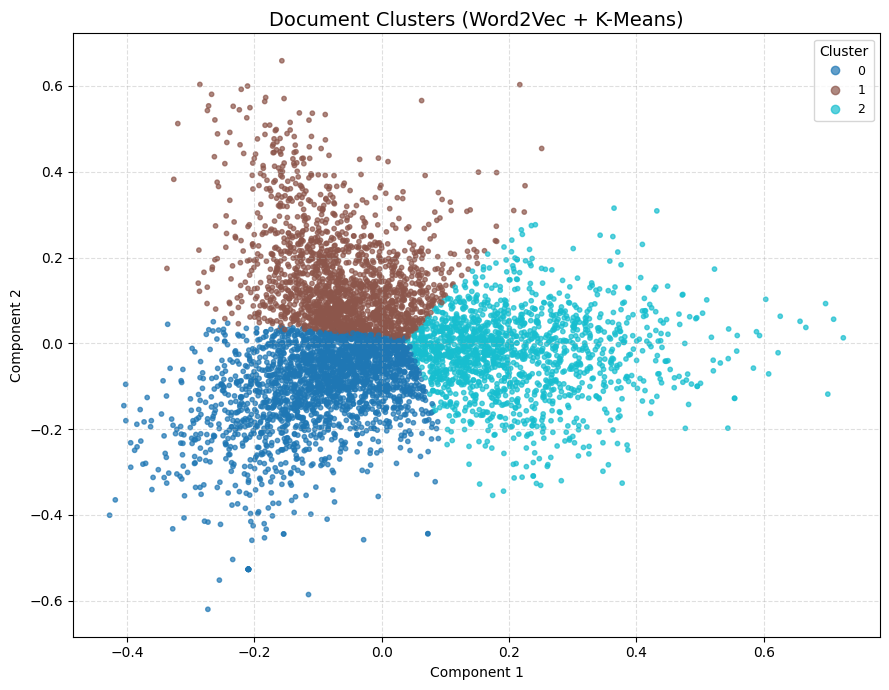

In [69]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

# Reduce document vectors to 2D for visualization
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(doc_vecs)

print("Shape after PCA:", X_2d.shape)

# Build plot
# ------------------------------------
plt.figure(figsize=(9, 7))
scatter = plt.scatter(
    X_2d[:, 0], X_2d[:, 1],
    c=df["cluster"], cmap="tab10", s=10, alpha=0.7
)

plt.title("Document Clusters (Word2Vec + K-Means)", fontsize=14)
plt.xlabel("Component 1")
plt.ylabel("Component 2")

# Optional: legend
plt.legend(
    *scatter.legend_elements(),
    title="Cluster",
    loc="best",
    fontsize=9
)

plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# mot -> regroup proposition  

The figure above displays the **semantic distribution of documents** in a two-dimensional space obtained through dimensionality reduction ( PCA ) applied to the TF-IDF–weighted Word2Vec document embeddings. Each point corresponds to a **citizen proposal** and colors represent the **three clusters**.

The clusters form **distinct but partially overlapping regions**, suggesting that the model successfully identified **coherent thematic zones** in the semantic space while capturing some degree of conceptual continuity between related topics.  
- **Cluster 0** (brown) occupies the upper region and appears semantically linked to *systemic and regulatory proposals* — topics emphasizing methods, regulations, and systemic perspectives.  
- **Cluster 1** (blue) lies centrally, representing *educational and communicative initiatives*, bridging policy-oriented and ecological clusters through discourse about awareness and pedagogy.  
- **Cluster 2** (lightblue) extends toward the right, associated with *ecological and spatial management themes* — vegetation, green spaces, and land-use practices.

The **compactness** of each color region indicates that the K-Means algorithm achieved **good intra-cluster cohesion**: documents within the same cluster exhibit similar semantic content.  
The **moderate overlap** between clusters reflects **lexical and conceptual continuity** across domains (e.g., education and environment, or regulation and sustainability), which is natural in open participatory text data.  
Overall, the visualization provides a **qualitative validation** of the numerical clustering results, confirming that the hybrid embedding pipeline (Word2Vec + TF-IDF weighting) captures **meaningful, interpretable semantic structures** in the dataset.

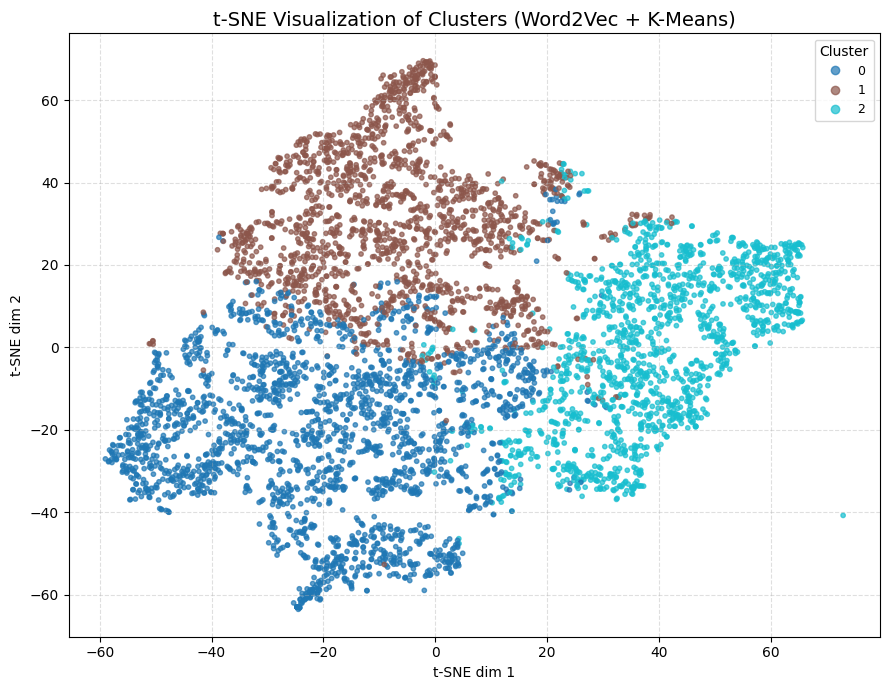

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    perplexity=40,     #controls the balance between local and global structure (corresponds to the expected number of neighbors each point considers)
    max_iter=1000,     # defines the number of optimization steps for convergence;
    random_state=42,
    init="pca",        #initializes the embedding using a principal component layout for faster convergence and more stable results
    learning_rate="auto"
)
X_2d = tsne.fit_transform(doc_vecs)


plt.figure(figsize=(9,7))
scatter = plt.scatter(
    X_2d[:,0], X_2d[:,1],
    c=df["cluster"], cmap="tab10", s=10, alpha=0.7
)

plt.title("t-SNE Visualization of Clusters (Word2Vec + K-Means)", fontsize=14)
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.legend(*scatter.legend_elements(), title="Cluster", loc="best", fontsize=9)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


**t-SNE (t-Distributed Stochastic Neighbor Embedding)**   
It preserves **local neighborhood relationships**: points that are close in the original high-dimensional embedding space remain close in the 2D (or 3D) projection.

Formally, t-SNE:
- Computes pairwise **similarity probabilities** between data points in the original space;  
- Maps them into a lower-dimensional space while minimizing the **Kullback–Leibler divergence** between the two distributions;  
- Emphasizes **local structure**, revealing clusters, subclusters, and dense semantic regions that might not be visible under linear projections such as PCA.

The three colored clusters represent the **semantic groupings** discovered by K-Means in the embedding space.  
- **Brown (Cluster 0)** occupies the upper region and corresponds to **systemic or regulatory proposals** emphasizing control, policy, or structural measures.  
- **Blue (Cluster 1)** is concentrated in the lower-left area and captures **educational and civic communication themes**, characterized by vocabulary related to learning, participation, and awareness.  
- **Lightblue (Cluster 2)** extends toward the right, representing **ecological and spatial management proposals**, focused on vegetation, land use, and urban nature.

The **clear spatial separation** among these clusters demonstrates that the semantic model effectively distinguishes between major thematic axes of public discourse on biodiversity.  
Minor overlaps at cluster boundaries indicate natural **conceptual continuity** between related themes — for instance, between education and environmental policy.